In [21]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import SGD, AdamW
from torch import nn

from sklearn.feature_extraction.text import TfidfVectorizer

from statistics import mean

In [2]:
import utils_generic as generic
import rrnn_modelo as rrnn
import logistic_regresion as lr

import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Datos ConvAI2

In [4]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [5]:
convai_train = data['train']
convai_val = data['validation']

vectorizer = TfidfVectorizer()

vectorizer.fit_transform(list(convai_train.keys()))

convai_train_token = generic.tokenize_dataset_rrnn2(convai_train,['about','to','as'],tfidf=vectorizer) 
convai_val_token = generic.tokenize_dataset_rrnn2(convai_val,['about','to','as'],tfidf=vectorizer) 

In [6]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_train_token,task,eval=False,tfidf=True)

In [7]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_val_token,task,eval=False,tfidf=True)

# Datos md_gender

In [8]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [9]:
md_tokenized = generic.tokenize_dataset_rrnn2(md_data,['about','to','as'],tfidf=vectorizer) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskRRNN(md_tokenized,task,eval=True,tfidf=True)

# Creación dataloaders

In [10]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn)

In [11]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn)

In [12]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn)

# ABOUT

In [13]:
max_sequence_len = 15088
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6910498814092696 	 Validation loss: 0.6886183538679349 	 
  1%|          | 574/57400 [00:13<36:19, 26.07it/s]
Epoch 2 	 Training loss: 0.6858756737426598 	 Validation loss: 0.6841192679890131 	 
  2%|▏         | 1148/57400 [00:26<19:42, 47.57it/s]
Epoch 3 	 Training loss: 0.681272744613242 	 Validation loss: 0.6800975466178636 	 
  3%|▎         | 1722/57400 [00:31<09:53, 93.84it/s]
Epoch 4 	 Training loss: 0.6771357784287855 	 Validation loss: 0.6766150906934576 	 
  4%|▍         | 2296/57400 [00:37<07:46, 118.09it/s]
Epoch 5 	 Training loss: 0.6734065567159486 	 Validation loss: 0.6733776098590786 	 
  5%|▌         | 2870/57400 [00:43<07:28, 121.59it/s]
Epoch 6 	 Training loss: 0.670023947227292 	 Validation loss: 0.6704219913078566 	 
  6%|▌         | 3444/57400 [00:49<07:57, 112.88it/s]
Epoch 7 	 Training loss: 0.666874325753089 	 Validation loss: 0.6677387851779744 	 
  7%|▋         | 4018/57400 [00:54<09:46, 90.96it/s]
Epoch 8 	 Training loss: 0.66401775

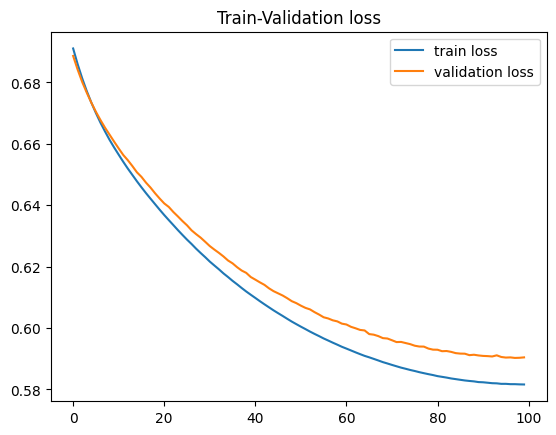

In [14]:
model = lr.LogisticRegression(max_sequence_len).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_lr_about1'
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [15]:
model = lr.LogisticRegression(max_sequence_len).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.625, 'precision': 0.625, 'f1': 0.625, 'accuracy': 0.625}
MALE {'recall': 0.9296875, 'precision': 0.9296875, 'f1': 0.9296875, 'accuracy': 0.9296875}
FEMALE {'recall': 0.3325, 'precision': 0.3325, 'f1': 0.3325, 'accuracy': 0.3325} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.577020202020202, 'precision': 0.577020202020202, 'f1': 0.577020202020202, 'accuracy': 0.577020202020202}
MALE {'recall': 0.8759124087591241, 'precision': 0.8759124087591241, 'f1': 0.8759124087591241, 'accuracy': 0.8759124087591241}
FEMALE {'recall': 0.2545931758530184, 'precision': 0.2545931758530184, 'f1': 0.2545931758530184, 'accuracy': 0.2545931758530184} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5723598435462842, 'precision': 0.5723598435462842, 'f1': 0.5723598435462842, 'accuracy': 0.5723598435462842}
MALE {'recall': 0.8686868686868687, 'precision': 0.8686868686868687, 'f1': 0.8686868686868688, 'accuracy': 0

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6901281817657191 	 Validation loss: 0.6879248972666465 	 
  1%|          | 574/57400 [00:05<08:06, 116.88it/s]
Epoch 2 	 Training loss: 0.6850953871572475 	 Validation loss: 0.6835369659682452 	 
  2%|▏         | 1148/57400 [00:11<10:21, 90.50it/s]
Epoch 3 	 Training loss: 0.6806388432971276 	 Validation loss: 0.6796771550582628 	 
  3%|▎         | 1722/57400 [00:17<07:27, 124.51it/s]
Epoch 4 	 Training loss: 0.676626795883378 	 Validation loss: 0.6764131168187675 	 
  4%|▍         | 2296/57400 [00:23<10:06, 90.83it/s]
Epoch 5 	 Training loss: 0.6729917154494893 	 Validation loss: 0.6731791223509836 	 
  5%|▌         | 2870/57400 [00:29<07:30, 120.97it/s]
Epoch 6 	 Training loss: 0.6696752618206503 	 Validation loss: 0.6702541890790907 	 
  6%|▌         | 3444/57400 [00:35<09:19, 96.44it/s]
Epoch 7 	 Training loss: 0.6666152746212192 	 Validation loss: 0.6676724553108215 	 
  7%|▋         | 4018/57400 [00:41<07:26, 119.52it/s]
Epoch 8 	 Training loss: 0.66379

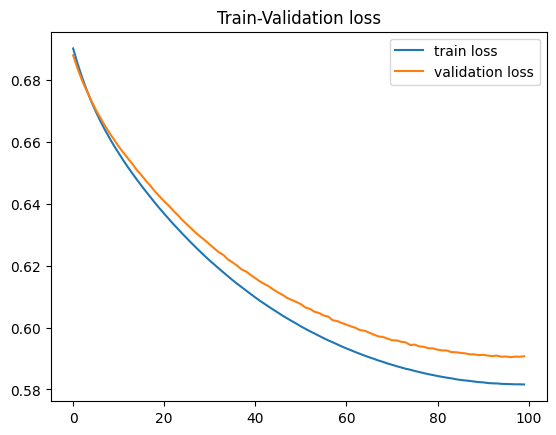

In [16]:
model = lr.LogisticRegression(max_sequence_len).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_lr_about2'
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [17]:
model = lr.LogisticRegression(max_sequence_len).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6262755102040817, 'precision': 0.6262755102040817, 'f1': 0.6262755102040817, 'accuracy': 0.6262755102040817}
MALE {'recall': 0.9296875, 'precision': 0.9296875, 'f1': 0.9296875, 'accuracy': 0.9296875}
FEMALE {'recall': 0.335, 'precision': 0.335, 'f1': 0.335, 'accuracy': 0.335} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.577020202020202, 'precision': 0.577020202020202, 'f1': 0.577020202020202, 'accuracy': 0.577020202020202}
MALE {'recall': 0.8759124087591241, 'precision': 0.8759124087591241, 'f1': 0.8759124087591241, 'accuracy': 0.8759124087591241}
FEMALE {'recall': 0.2545931758530184, 'precision': 0.2545931758530184, 'f1': 0.2545931758530184, 'accuracy': 0.2545931758530184} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5723598435462842, 'precision': 0.5723598435462842, 'f1': 0.5723598435462842, 'accuracy': 0.5723598435462842}
MALE {'recall': 0.8686868686868687, 'precision': 0.868686868

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6903874534555429 	 Validation loss: 0.6880511661707345 	 
  1%|          | 574/57400 [00:05<09:21, 101.26it/s]
Epoch 2 	 Training loss: 0.6853002383526194 	 Validation loss: 0.6836672465680009 	 
  2%|▏         | 1148/57400 [00:11<10:08, 92.38it/s]
Epoch 3 	 Training loss: 0.680784194207773 	 Validation loss: 0.6797817864660489 	 
  3%|▎         | 1722/57400 [00:17<09:02, 102.61it/s]
Epoch 4 	 Training loss: 0.6767219250002805 	 Validation loss: 0.6761904803373046 	 
  4%|▍         | 2296/57400 [00:23<09:56, 92.42it/s]
Epoch 5 	 Training loss: 0.6730556034252618 	 Validation loss: 0.6730176776142444 	 
  5%|▌         | 2870/57400 [00:29<08:14, 110.34it/s]
Epoch 6 	 Training loss: 0.6697248140486275 	 Validation loss: 0.6702320696943898 	 
  6%|▌         | 3444/57400 [00:35<09:26, 95.25it/s]
Epoch 7 	 Training loss: 0.6666413407500197 	 Validation loss: 0.6676805736654896 	 
  7%|▋         | 4018/57400 [00:41<08:13, 108.09it/s]
Epoch 8 	 Training loss: 0.66376

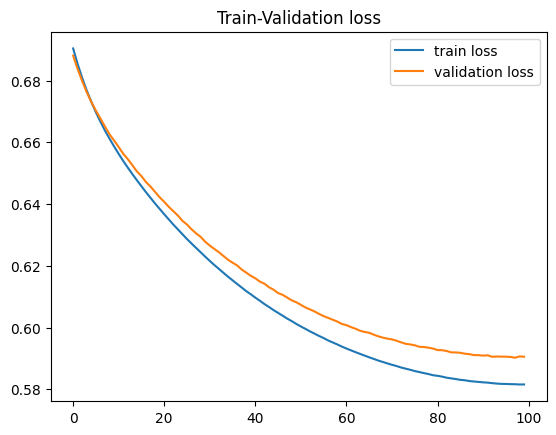

In [18]:
model = lr.LogisticRegression(max_sequence_len).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_lr_about3'
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [19]:
model = lr.LogisticRegression(max_sequence_len).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.625, 'precision': 0.625, 'f1': 0.625, 'accuracy': 0.625}
MALE {'recall': 0.9296875, 'precision': 0.9296875, 'f1': 0.9296875, 'accuracy': 0.9296875}
FEMALE {'recall': 0.3325, 'precision': 0.3325, 'f1': 0.3325, 'accuracy': 0.3325} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.577020202020202, 'precision': 0.577020202020202, 'f1': 0.577020202020202, 'accuracy': 0.577020202020202}
MALE {'recall': 0.8759124087591241, 'precision': 0.8759124087591241, 'f1': 0.8759124087591241, 'accuracy': 0.8759124087591241}
FEMALE {'recall': 0.2545931758530184, 'precision': 0.2545931758530184, 'f1': 0.2545931758530184, 'accuracy': 0.2545931758530184} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5710560625814863, 'precision': 0.5710560625814863, 'f1': 0.5710560625814863, 'accuracy': 0.5710560625814863}
MALE {'recall': 0.8686868686868687, 'precision': 0.8686868686868687, 'f1': 0.8686868686868688, 'accuracy': 0

In [22]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.6254251700680272, 'precision': 0.6254251700680272, 'f1': 0.6254251700680272, 'accuracy': 0.6254251700680272}
Métricas etiqueta male: {'recall': 0.9296875, 'precision': 0.9296875, 'f1': 0.9296875, 'accuracy': 0.9296875}
Métricas etiqueta female:  {'recall': 0.33333333333333337, 'precision': 0.33333333333333337, 'f1': 0.33333333333333337, 'accuracy': 0.33333333333333337}

 to
Resultado global: {'recall': 0.577020202020202, 'precision': 0.577020202020202, 'f1': 0.577020202020202, 'accuracy': 0.577020202020202}
Métricas etiqueta male: {'recall': 0.8759124087591241, 'precision': 0.8759124087591241, 'f1': 0.8759124087591241, 'accuracy': 0.8759124087591241}
Métricas etiqueta female:  {'recall': 0.2545931758530184, 'precision': 0.2545931758530184, 'f1': 0.2545931758530184, 'accuracy': 0.2545931758530184}

 as
Resultado global: {'recall': 0.5719252498913516, 'precision': 0.5719252498913516, 'f1': 0.5719252498913516, 'accuracy': 0.57192

# TO

In [23]:
max_sequence_len = 15088
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6931180733836901 	 Validation loss: 0.6928936061212572 	 
  1%|          | 574/57400 [00:09<15:41, 60.37it/s]
Epoch 2 	 Training loss: 0.6930645537085649 	 Validation loss: 0.6928841885873827 	 
  2%|▏         | 1148/57400 [00:16<10:39, 88.00it/s]
Epoch 3 	 Training loss: 0.6930192480519258 	 Validation loss: 0.6928980441416724 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:23<08:44, 106.10it/s]
Epoch 4 	 Training loss: 0.6929819017960219 	 Validation loss: 0.6929624444347317 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:31<10:14, 89.68it/s]
Epoch 5 	 Training loss: 0.6928999907879049 	 Validation loss: 0.692835723949691 	 
  5%|▌         | 2870/57400 [00:38<09:43, 93.53it/s]
Epoch 6 	 Training loss: 0.6928362678152343 	 Validation loss: 0.6928768814620325 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:45<12:14, 73.48it/s]
Epoch 7 	 Training loss: 0.6927907097215021 	 Validation loss: 0.692938128770408 	 

2

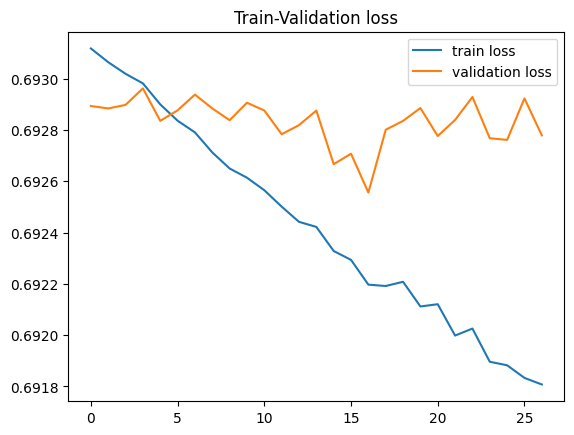

In [24]:
model = lr.LogisticRegression(max_sequence_len).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_lr_to1'
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [25]:
model = lr.LogisticRegression(max_sequence_len).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5267857142857143, 'precision': 0.5267857142857143, 'f1': 0.5267857142857143, 'accuracy': 0.5267857142857143}
MALE {'recall': 0.16666666666666666, 'precision': 0.16666666666666666, 'f1': 0.16666666666666666, 'accuracy': 0.16666666666666666}
FEMALE {'recall': 0.8725, 'precision': 0.8725, 'f1': 0.8725, 'accuracy': 0.8725} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5997474747474747, 'precision': 0.5997474747474747, 'f1': 0.5997474747474747, 'accuracy': 0.5997474747474747}
MALE {'recall': 0.3357664233576642, 'precision': 0.3357664233576642, 'f1': 0.3357664233576642, 'accuracy': 0.3357664233576642}
FEMALE {'recall': 0.884514435695538, 'precision': 0.884514435695538, 'f1': 0.884514435695538, 'accuracy': 0.884514435695538} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5176010430247718, 'precision': 0.5176010430247718, 'f1': 0.5176010430247718, 'accuracy': 0.5176010430247718}
MALE {'recall': 

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6931639374963913 	 Validation loss: 0.6930712815058433 	 
  1%|          | 574/57400 [00:07<11:26, 82.77it/s]
Epoch 2 	 Training loss: 0.693070605968349 	 Validation loss: 0.6929070343405513 	 
  2%|▏         | 1148/57400 [00:14<11:50, 79.16it/s]
Epoch 3 	 Training loss: 0.6930417873302819 	 Validation loss: 0.6929463582523798 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:22<11:26, 81.08it/s]
Epoch 4 	 Training loss: 0.6929434708186558 	 Validation loss: 0.6929249187647286 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:29<11:18, 81.27it/s]
Epoch 5 	 Training loss: 0.692862016606414 	 Validation loss: 0.6928416692604453 	 
  5%|▌         | 2870/57400 [00:37<08:35, 105.88it/s]
Epoch 6 	 Training loss: 0.6928335897598532 	 Validation loss: 0.6929386308637716 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:44<11:18, 79.55it/s]
Epoch 7 	 Training loss: 0.692749034133107 	 Validation loss: 0.6929187996912811 	 

2 

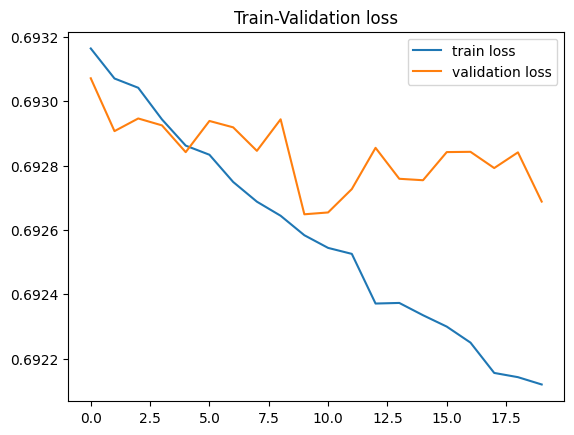

In [26]:
model = lr.LogisticRegression(max_sequence_len).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_lr_to2'
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [27]:
model = lr.LogisticRegression(max_sequence_len).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5153061224489796, 'precision': 0.5153061224489796, 'f1': 0.5153061224489796, 'accuracy': 0.5153061224489796}
MALE {'recall': 0.08333333333333333, 'precision': 0.08333333333333333, 'f1': 0.08333333333333333, 'accuracy': 0.08333333333333333}
FEMALE {'recall': 0.93, 'precision': 0.93, 'f1': 0.93, 'accuracy': 0.93} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.51010101010101, 'precision': 0.51010101010101, 'f1': 0.51010101010101, 'accuracy': 0.51010101010101}
MALE {'recall': 0.1070559610705596, 'precision': 0.1070559610705596, 'f1': 0.1070559610705596, 'accuracy': 0.1070559610705596}
FEMALE {'recall': 0.9448818897637795, 'precision': 0.9448818897637795, 'f1': 0.9448818897637795, 'accuracy': 0.9448818897637795} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4915254237288136, 'precision': 0.4915254237288136, 'f1': 0.4915254237288136, 'accuracy': 0.4915254237288136}
MALE {'recall': 0.0707070707

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.693147975185607 	 Validation loss: 0.6929573497529757 	 
  1%|          | 574/57400 [00:07<10:17, 91.96it/s]
Epoch 2 	 Training loss: 0.6930514567820453 	 Validation loss: 0.6928901924925336 	 
  2%|▏         | 1148/57400 [00:13<09:57, 94.13it/s]
Epoch 3 	 Training loss: 0.6930271956148047 	 Validation loss: 0.6929591591075316 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:21<09:30, 97.57it/s]
Epoch 4 	 Training loss: 0.6929447535646086 	 Validation loss: 0.6929437194840383 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:28<11:39, 78.80it/s]
Epoch 5 	 Training loss: 0.6928903774101975 	 Validation loss: 0.6928856756727574 	 
  5%|▌         | 2870/57400 [00:35<11:05, 81.88it/s]
Epoch 6 	 Training loss: 0.6928237589394174 	 Validation loss: 0.6929017810498254 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:43<10:14, 87.78it/s]
Epoch 7 	 Training loss: 0.6927441365835143 	 Validation loss: 0.6927107532145613 	 
  

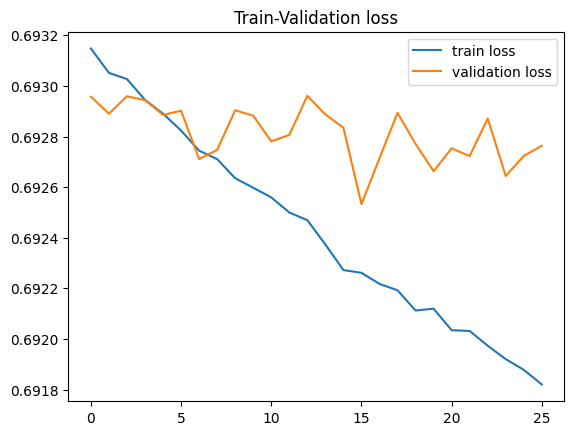

In [28]:
model = lr.LogisticRegression(max_sequence_len).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_lr_to3'
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [29]:
model = lr.LogisticRegression(max_sequence_len).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5204081632653061, 'precision': 0.5204081632653061, 'f1': 0.5204081632653061, 'accuracy': 0.5204081632653061}
MALE {'recall': 0.14583333333333334, 'precision': 0.14583333333333334, 'f1': 0.14583333333333334, 'accuracy': 0.14583333333333334}
FEMALE {'recall': 0.88, 'precision': 0.88, 'f1': 0.88, 'accuracy': 0.88} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5618686868686869, 'precision': 0.5618686868686869, 'f1': 0.5618686868686869, 'accuracy': 0.5618686868686869}
MALE {'recall': 0.24817518248175183, 'precision': 0.24817518248175183, 'f1': 0.24817518248175183, 'accuracy': 0.24817518248175183}
FEMALE {'recall': 0.9002624671916011, 'precision': 0.9002624671916011, 'f1': 0.9002624671916011, 'accuracy': 0.9002624671916011} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5228161668839635, 'precision': 0.5228161668839635, 'f1': 0.5228161668839635, 'accuracy': 0.5228161668839635}
MALE {'recall': 

In [30]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5208333333333334, 'precision': 0.5208333333333334, 'f1': 0.5208333333333334, 'accuracy': 0.5208333333333334}
Métricas etiqueta male: {'recall': 0.13194444444444445, 'precision': 0.13194444444444445, 'f1': 0.13194444444444445, 'accuracy': 0.13194444444444445}
Métricas etiqueta female:  {'recall': 0.8941666666666667, 'precision': 0.8941666666666667, 'f1': 0.8941666666666667, 'accuracy': 0.8941666666666667}

 to
Resultado global: {'recall': 0.5572390572390572, 'precision': 0.5572390572390572, 'f1': 0.5572390572390572, 'accuracy': 0.5572390572390572}
Métricas etiqueta male: {'recall': 0.2303325223033252, 'precision': 0.2303325223033252, 'f1': 0.2303325223033252, 'accuracy': 0.2303325223033252}
Métricas etiqueta female:  {'recall': 0.9098862642169728, 'precision': 0.9098862642169728, 'f1': 0.9098862642169728, 'accuracy': 0.9098862642169728}

 as
Resultado global: {'recall': 0.5106475445458496, 'precision': 0.5106475445458496, 'f1':

# AS

In [31]:
max_sequence_len = 15088
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6930732456026177 	 Validation loss: 0.6929743936506368 	 
  1%|          | 574/57400 [00:07<08:50, 107.07it/s]
Epoch 2 	 Training loss: 0.6929179516195836 	 Validation loss: 0.6929157588441494 	 
  2%|▏         | 1148/57400 [00:14<11:25, 82.03it/s]
Epoch 3 	 Training loss: 0.6927231461951957 	 Validation loss: 0.6929221506846153 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:22<11:38, 79.67it/s]
Epoch 4 	 Training loss: 0.6925411479813712 	 Validation loss: 0.6928643038717367 	 
  4%|▍         | 2296/57400 [00:29<09:07, 100.60it/s]
Epoch 5 	 Training loss: 0.6923877430709813 	 Validation loss: 0.6927407697095709 	 
  5%|▌         | 2870/57400 [00:36<11:49, 76.83it/s]
Epoch 6 	 Training loss: 0.6922329851143867 	 Validation loss: 0.6926240375486471 	 
  6%|▌         | 3444/57400 [00:43<08:43, 103.10it/s]
Epoch 7 	 Training loss: 0.6920269657095135 	 Validation loss: 0.6925776701862529 	 
  7%|▋         | 4018/57400 [00:51<11:59, 74.18it/s]
Epo

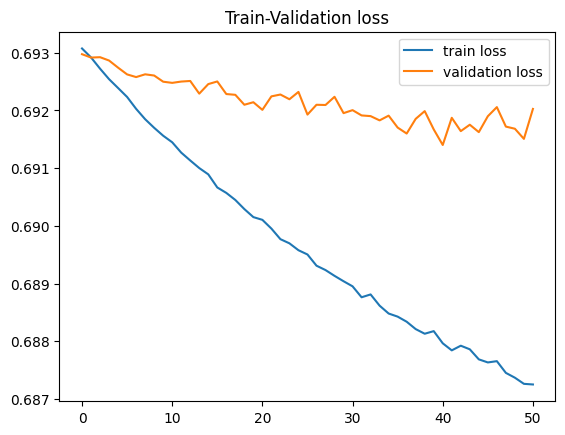

In [32]:
model = lr.LogisticRegression(max_sequence_len).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_lr_as1'
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [33]:
model = lr.LogisticRegression(max_sequence_len).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.48086734693877553, 'precision': 0.48086734693877553, 'f1': 0.48086734693877553, 'accuracy': 0.48086734693877553}
MALE {'recall': 0.5234375, 'precision': 0.5234375, 'f1': 0.5234375, 'accuracy': 0.5234375}
FEMALE {'recall': 0.44, 'precision': 0.44, 'f1': 0.44, 'accuracy': 0.44} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6136363636363636, 'precision': 0.6136363636363636, 'f1': 0.6136363636363636, 'accuracy': 0.6136363636363636}
MALE {'recall': 0.7347931873479319, 'precision': 0.7347931873479319, 'f1': 0.7347931873479319, 'accuracy': 0.7347931873479319}
FEMALE {'recall': 0.48293963254593175, 'precision': 0.48293963254593175, 'f1': 0.48293963254593175, 'accuracy': 0.48293963254593175} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6114732724902217, 'precision': 0.6114732724902217, 'f1': 0.6114732724902217, 'accuracy': 0.6114732724902217}
MALE {'recall': 0.5934343434343434, 'precision': 0.5

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6931010966516953 	 Validation loss: 0.6930487408476361 	 
  1%|          | 574/57400 [00:06<11:13, 84.37it/s]
Epoch 2 	 Training loss: 0.6929258898367865 	 Validation loss: 0.6929549332392417 	 
  2%|▏         | 1148/57400 [00:14<11:32, 81.25it/s]
Epoch 3 	 Training loss: 0.6927427675458196 	 Validation loss: 0.692959595534761 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:21<11:43, 79.12it/s]
Epoch 4 	 Training loss: 0.6925570742593825 	 Validation loss: 0.6927611736928002 	 
  4%|▍         | 2296/57400 [00:28<08:41, 105.59it/s]
Epoch 5 	 Training loss: 0.6923709201272772 	 Validation loss: 0.6928365695274482 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:35<11:02, 82.25it/s]
Epoch 6 	 Training loss: 0.6922490341322762 	 Validation loss: 0.692717246079849 	 
  6%|▌         | 3444/57400 [00:42<11:20, 79.26it/s]
Epoch 7 	 Training loss: 0.692053031838314 	 Validation loss: 0.6925471808950779 	 
  7%|▋         | 4018/57400 [00:

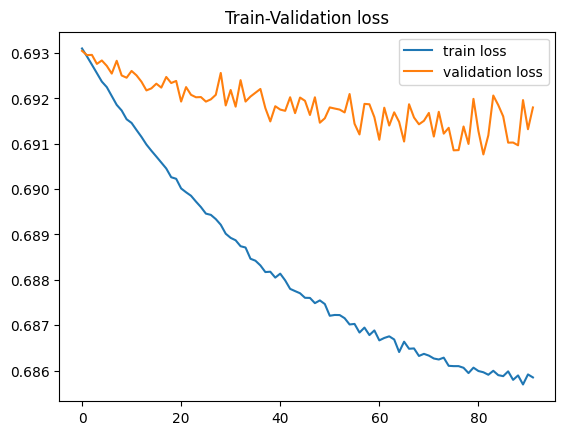

In [34]:
model = lr.LogisticRegression(max_sequence_len).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_lr_as2'
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [35]:
model = lr.LogisticRegression(max_sequence_len).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.47959183673469385, 'precision': 0.47959183673469385, 'f1': 0.47959183673469385, 'accuracy': 0.47959183673469385}
MALE {'recall': 0.5364583333333334, 'precision': 0.5364583333333334, 'f1': 0.5364583333333334, 'accuracy': 0.5364583333333334}
FEMALE {'recall': 0.425, 'precision': 0.425, 'f1': 0.425, 'accuracy': 0.425} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.61489898989899, 'precision': 0.61489898989899, 'f1': 0.61489898989899, 'accuracy': 0.61489898989899}
MALE {'recall': 0.7493917274939172, 'precision': 0.7493917274939172, 'f1': 0.7493917274939172, 'accuracy': 0.7493917274939172}
FEMALE {'recall': 0.46981627296587924, 'precision': 0.46981627296587924, 'f1': 0.46981627296587924, 'accuracy': 0.46981627296587924} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6205997392438071, 'precision': 0.6205997392438071, 'f1': 0.6205997392438071, 'accuracy': 0.6205997392438071}
MALE {'recall': 0.61

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6930957401255697 	 Validation loss: 0.693132259077945 	 
  1%|          | 574/57400 [00:07<11:45, 80.49it/s]
Epoch 2 	 Training loss: 0.6929074911082663 	 Validation loss: 0.6930806667117749 	 
  2%|▏         | 1148/57400 [00:14<09:06, 102.95it/s]
Epoch 3 	 Training loss: 0.6927179806323832 	 Validation loss: 0.6929405220484329 	 
  3%|▎         | 1722/57400 [00:21<11:41, 79.39it/s]
Epoch 4 	 Training loss: 0.6925511755802075 	 Validation loss: 0.6928414722620431 	 
  4%|▍         | 2296/57400 [00:28<11:13, 81.85it/s]
Epoch 5 	 Training loss: 0.6923704498320922 	 Validation loss: 0.6927600553480245 	 
  5%|▌         | 2870/57400 [00:35<11:31, 78.86it/s]
Epoch 6 	 Training loss: 0.6922035895365871 	 Validation loss: 0.6928428926710355 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:42<08:29, 105.81it/s]
Epoch 7 	 Training loss: 0.6920263937541417 	 Validation loss: 0.69265428438025 	 
  7%|▋         | 4018/57400 [00:49<11:02, 80.62it/s]
Epoch 8

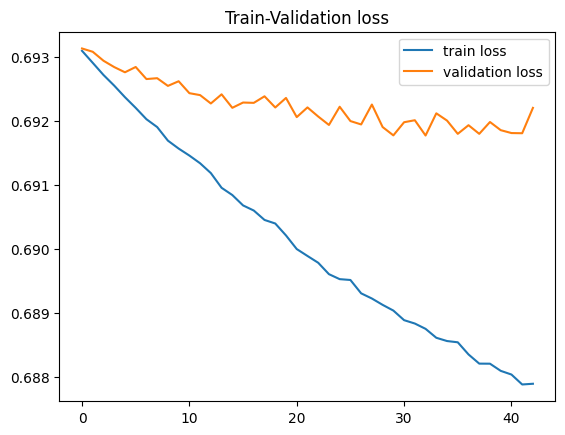

In [36]:
model = lr.LogisticRegression(max_sequence_len).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_lr_as3'
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [37]:
model = lr.LogisticRegression(max_sequence_len).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4846938775510204, 'precision': 0.4846938775510204, 'f1': 0.4846938775510204, 'accuracy': 0.4846938775510204}
MALE {'recall': 0.4947916666666667, 'precision': 0.4947916666666667, 'f1': 0.4947916666666667, 'accuracy': 0.4947916666666667}
FEMALE {'recall': 0.475, 'precision': 0.475, 'f1': 0.47500000000000003, 'accuracy': 0.475} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6174242424242424, 'precision': 0.6174242424242424, 'f1': 0.6174242424242424, 'accuracy': 0.6174242424242424}
MALE {'recall': 0.7201946472019465, 'precision': 0.7201946472019465, 'f1': 0.7201946472019465, 'accuracy': 0.7201946472019465}
FEMALE {'recall': 0.5065616797900262, 'precision': 0.5065616797900262, 'f1': 0.5065616797900262, 'accuracy': 0.5065616797900262} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6179921773142112, 'precision': 0.6179921773142112, 'f1': 0.6179921773142112, 'accuracy': 0.6179921773142112}
MALE {

In [38]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.4817176870748299, 'precision': 0.4817176870748299, 'f1': 0.4817176870748299, 'accuracy': 0.4817176870748299}
Métricas etiqueta male: {'recall': 0.5182291666666667, 'precision': 0.5182291666666667, 'f1': 0.5182291666666667, 'accuracy': 0.5182291666666667}
Métricas etiqueta female:  {'recall': 0.44666666666666666, 'precision': 0.44666666666666666, 'f1': 0.44666666666666666, 'accuracy': 0.44666666666666666}

 to
Resultado global: {'recall': 0.6153198653198654, 'precision': 0.6153198653198654, 'f1': 0.6153198653198654, 'accuracy': 0.6153198653198654}
Métricas etiqueta male: {'recall': 0.7347931873479319, 'precision': 0.7347931873479319, 'f1': 0.7347931873479319, 'accuracy': 0.7347931873479319}
Métricas etiqueta female:  {'recall': 0.4864391951006124, 'precision': 0.4864391951006124, 'f1': 0.4864391951006124, 'accuracy': 0.4864391951006124}

 as
Resultado global: {'recall': 0.6166883963494133, 'precision': 0.6166883963494133, 'f1':